# Quantum Random Access Optimization

The Quantum Random Access Optimization (QRAO) module is designed to enable users to leverage a new quantum method for combinatorial optimization problems [1]. This approach incorporates Quantum Random Access Codes (QRACs) as a tool to encode multiple classical binary variables into a single qubit, thereby saving quantum resources and enabling exploration of larger problem instances on a quantum computer. The encodings produce a local quantum Hamiltonian whose ground state can be approximated with standard algorithms such as VQE, and then rounded to yield approximation solutions of the original problem.

QRAO through a series of 3 classes:
1. The encoding class (`QuantumRandomAccessEncoding`): This class encodes the original problem into a relaxed problem that requires fewer resources to solve.
2. The rounding schemes (`SemideterministicRounding` and `MagicRounding`): This scheme is used to round the solution obtained from the relaxed problem back to a solution of the original problem.
3. The optimizer class (`QuantumRandomAccessOptimizer`): This class performs the high-level optimization algorithm, utilizing the capabilities of the encoding class and the rounding scheme.


*References*

[1] Bryce Fuller et al., *Approximate Solutions of Combinatorial Problems via Quantum Relaxations,*  [arXiv:2111.03167](https://arxiv.org/abs/2111.03167)

In [1]:
from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessEncoding,
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)

## Set up a combinatorial optimization problem

In this tutorial, we will consider a random max-cut problem instance and use QRAO to try to find a maximum cut; in other words, a partition of the graph's vertices (nodes) into two sets that maximizes the number of edges between the sets.

To begin, we utilize the `Maxcut` class from Qiskit Optimization's application module. It allows us to generate a `QuadraticProgram` representation of the given graph.

Note that once our problem has been represented as a `QuadraticProgram`, it will need to be converted to the correct type, a [quadratic unconstrained binary optimization (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) problem, so that it is compatible with QRAO.
A `QuadraticProgram` generated by `Maxcut` is already a QUBO, but if you define your own problem be sure you convert it to a QUBO before proceeding. Here is [a tutorial](https://qiskit-community.github.io/qiskit-optimization/tutorials/02_converters_for_quadratic_programs.html) on converting `QuadraticPrograms`.

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



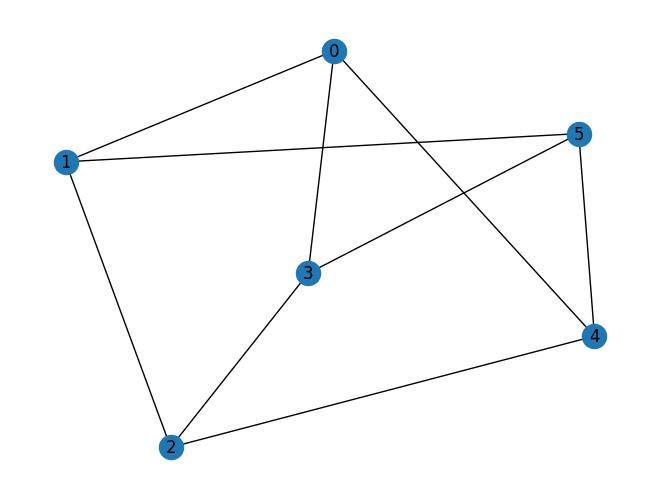

In [2]:
import networkx as nx
from qiskit_optimization.applications import Maxcut

seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

## Encode the problem into a quantum Hamiltonian

Once we have appropriately configured our problem, we proceed to encode it using the `QuantumRandomAccessEncoding` class from the `qrao` module. This encoding step allows us to generate a quantum Hamiltonian operator that represents our problem. In particular, we employ a Quantum Random Access Code (QRAC) to encode multiple classical binary variables (corresponding to the nodes of our max-cut graph) into each qubit.

It's important to note that the resulting "relaxed" Hamiltonian, produced by this encoding, will not be diagonal. This differs from the standard workflow in `qiskit-optimization`, which typically generates a diagonal (Ising) Hamiltonian suitable for optimization using a `MinimumEigenOptimizer`. You can find a tutorial on the `MinimumEigenOptimizer` [here](https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html).

In our encoding process, we employ a $(3,1,p)-$QRAC, where each qubit can accommodate a maximum of 3 classical binary variables. The parameter $p$ represents the bit recovery probability achieved through measurement. Depending on the nature of the problem, some qubits may have fewer than 3 classical variables assigned to them. To evaluate the compression achieved, we can examine the `compression_ratio` attribute of the encoding, which provides the ratio between the number of original binary variables and the number of qubits used (at best, a factor of 3).

In [3]:
from qiskit_optimization.algorithms.qrao import QuantumRandomAccessEncoding

# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian
encoding.encode(problem)

# This is our encoded Hamiltonian
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( SparsePauliOp(['XX', 'XY', 'XZ', 'YX', 'ZX', 'YY', 'YZ', 'ZY', 'ZZ'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j]) ).

We achieve a compression ratio of (6 binary variables : 2 qubits) ≈ 3.0.



## Solve the problem using the `QuantumRandomAccessOptimizer`

Having successfully encoded our input problem as a relaxed Hamiltonian, we proceed to solve it using the `QuantumRandomAccessOptimizer`. This optimizer allows us to find an approximate solution to the relaxed problem by leveraging quantum computing techniques.

To set up the optimizer, we need to specify two crucial components:

1. **Minimum Eigensolver**: We specify a minimum eigensolver to heuristically search for the ground state of the relaxed problem Hamiltonian. As an example, we can use the Variational Quantum Eigensolver (VQE). For simulation purposes, we'll employ an simulator, but you can choose a quantum device as the backend if desired.
2. **Rounding Scheme**: To map the ground state results back to a solution for the original problem, we specify a rounding scheme. By default, the `SemideterministicRounding` is used, but alternative scheme, `MagicRounding`, is also available.

In [4]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)
from qiskit_optimization.minimum_eigensolvers import VQE
from qiskit_optimization.optimizers import COBYLA

# Prepare the VQE algorithm
ansatz = RealAmplitudes(2)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=Estimator(),
)

# Use semi-deterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
semidterministic_rounding = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=semidterministic_rounding)

/var/folders/f9/_1j2txjx3bn64hm6jkx7mwf80000gn/T/ipykernel_28184/1319438136.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator(),


Finally, we move forward with solving the problem by invoking the `solve()` method. It's important to note that when calling `solve()`, we pass the `problem` itself as an argument. Although we previously used `encode()` in `QuantumRandomAccessEncoding` to provide a clear understanding of the flow, `solve(problem)` automatically encodes the problem internally using `QuantumRandomAccessEncoding`. This provides a streamlined and simplified workflow that eliminates the need for explicit encoding steps.

The result is provides us as a `QuantumRandomAccessOptimizationResult`.
The `x` contains the binary values representing the best solution found, while the `fval` contains the corresponding objective value.

The `relaxed_fval` provides the expectation value of the relaxed Hamiltonian, adjusted to be in the units of the original optimization problem. For maximization problems, the best possible relaxed function value will always be greater than or equal to the best possible objective function value of the original problem. In practice, this often holds true for the best found value and best found objective function value as well.

In [5]:
# Solve the optimization problem
results = qrao.solve(problem)

print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The objective function value: 5.0
x: [1 0 0 1 0 1]
relaxed function value: 8.99999998822986



### Interpret the solution

In the context of [max-cut](https://en.wikipedia.org/wiki/Maximum_cut), the result's "optimal value" tells us which subset each node belongs to given the partition found by the optimizer.

The obtained solution places a partition between nodes [1, 2, 4] and nodes [0, 3, 5].


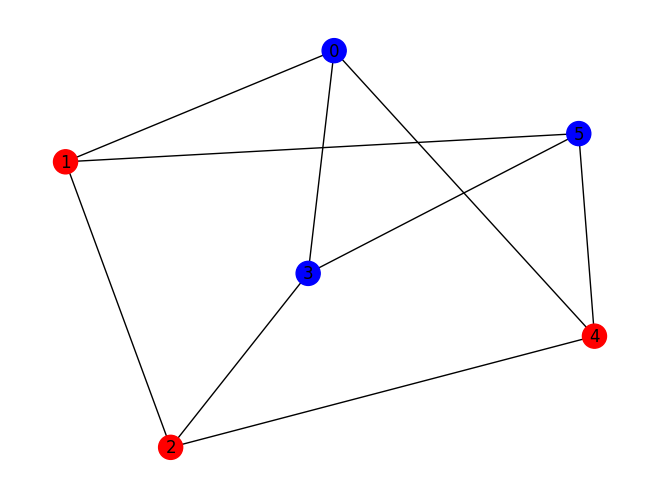

In [6]:
maxcut_partition = maxcut.interpret(results)
print(
    f"The obtained solution places a partition between nodes {maxcut_partition[0]} "
    f"and nodes {maxcut_partition[1]}."
)
maxcut.draw(results, pos=nx.spring_layout(graph, seed=seed))

### Inspect the results of subroutines

The `MinimumEigensolverResult` that results from performing VQE on the relaxed Hamiltonian is available:

In [7]:
results.relaxed_result

The result of the rounding scheme is also worth considering. In this example, we used the `SemideterministricRounding`. It's important to note that with semi-deterministic rounding, a single sample is generated as the result, making it the optimal solution candidate.

However, if we use the `MagicRounding` instead, multiple samples would be generated, each with a probability associated with it. These probabilities sum up to one, providing a distribution of potential optimal solutions.

In [8]:
results.samples

[SolutionSample(x=array([1, 0, 0, 1, 0, 1]), fval=np.float64(5.0), probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)]

### Exact Problem Solution with the `NumpyMinimumEigensolver`

To assess the performance of QRAO in approximating the optimal solution, we can utilize the `NumpyMinimumEigensolver`, an exact classical optimizer. We can obtain the exact optimal solution to the problem as follows:

In [9]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver

exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(problem)
print(exact_result.prettyprint())

objective function value: 9.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


The approximation ratio (QRAO's objective function value divided by the optimal objective function value) tells us how closely QRAO approximated the optimal solution to the problem.

In [10]:
print("QRAO Approximate Optimal Function Value:", results.fval)
print("Exact Optimal Function Value:", exact_result.fval)
print(f"Approximation Ratio: {results.fval /  exact_result.fval :.2f}")

QRAO Approximate Optimal Function Value: 5.0
Exact Optimal Function Value: 9.0
Approximation Ratio: 0.56


## Solve the problem using the `QuantumRandomAccessOptimizer` with `MagicRounding`

Magic rounding is a quantum technique employed to map the ground state results of our encoded Hamiltonian back to a solution of the original problem. Unlike semi-deterministic rounding, magic rounding requires a quantum backend, which can be either hardware or a simulator. 
The backend is passed to the `MagicRounding` class through a `Sampler`, which also determines the total number of shots (samples) that magic rounding will utilize. Note that to specify the backend, you need to choose a `Sampler` from providers such as Aer or IBM Runtime. Consequently, we need to specify `Estimator` and `Sampler` for the optimizer and the rounding scheme, respectively.

In practice, users may choose to set a significantly higher number of magic rounding shots compared to the shots used by the minimum eigensolver for the relaxed problem. This difference arises because the minimum eigensolver estimates expectation values, while the magic rounding scheme returns the sample corresponding to the maximum function value found.  The number of magic rounding shots directly impacts the diversity of the computational basis we can generate.
When estimating an expectation value, increasing the number of shots enhances the convergence to the true value. However, when aiming to identify the largest possible function value, we often sample from the tail of a distribution of outcomes. As a result, until we observe the highest value outcome in our distribution, each additional shot increases the expected return value.

In this tutorial, we use the `Estimator` for solving the relaxed Hamiltonian and the `Sampler` for performing magic rounding. Here, 10 times as many shots are used in the `Sampler`. As the number of qubits increases, you may need more shots or `weighted` basis sampling, as explained above."

In [11]:
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms.qrao import MagicRounding

estimator = Estimator(options={"shots": 1000, "seed": seed})
sampler = Sampler(options={"shots": 10000, "seed": seed})

# Prepare the VQE algorithm
ansatz = RealAmplitudes(2)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=estimator,
)


# Use magic rounding
magic_rounding = MagicRounding(sampler=sampler)

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=magic_rounding)

results = qrao.solve(problem)

/var/folders/f9/_1j2txjx3bn64hm6jkx7mwf80000gn/T/ipykernel_28184/2781876902.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1000, "seed": seed})
/var/folders/f9/_1j2txjx3bn64hm6jkx7mwf80000gn/T/ipykernel_28184/2781876902.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots": 10000, "seed": seed})


In [12]:
print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The objective function value: 9.0
x: [0 1 0 1 1 0]
relaxed function value: 8.99999890219597



Since magic rounding relies on nondeterministic measurements, the method collects a number of samples based on the shots count provided to the `Sampler` mentioned earlier. These samples are then consolidated, taking into account duplicates and calculating the empirical probability for each `SolutionSample`. Each sample in the consolidation process includes a corresponding function value (`fval`).

From the consolidated samples, we select the sample with the "optimal" function value. In the case of a max-cut problem, this means choosing the sample with the largest function value as our solution.

In [13]:
print(f"The number of distinct samples is {len(results.samples)}.")
print("Top 10 samples with the largest fval:")
for sample in results.samples[:10]:
    print(sample)

The number of distinct samples is 56.
Top 10 samples with the largest fval:
SolutionSample(x=array([0, 1, 0, 1, 1, 0]), fval=np.float64(9.0), probability=np.float64(0.0343), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 0, 1, 0, 0, 1]), fval=np.float64(9.0), probability=np.float64(0.0277), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 0, 0, 1, 1, 0]), fval=np.float64(6.0), probability=np.float64(0.0196), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 1, 1, 0, 0, 1]), fval=np.float64(6.0), probability=np.float64(0.0207), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 1, 0, 0, 1, 0]), fval=np.float64(6.0), probability=np.float64(0.02), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 0, 1, 1, 0, 1]), fval=np.float64(6.0), probability=np.float64(0.021), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 1, 0, 1, 0, 0]), fval=np.float64(6.0

## Alternative: Solve the Problem in Two Explicit Steps

In the previous part of this tutorial, we utilized the `qrao.solve()` method, which solved the encoded problem (the ground state of the relaxed Hamiltonian) and performed rounding to map the ground state results back to a solution of the original problem. However, it is also possible to explicitly break down the calculation into these two distinct steps. This can be beneficial, especially when comparing solutions obtained across multiple rounding schemes applied to a candidate ground state.

In this section, we will explore how to perform each of these steps explicitly.

## Manually solve the relaxed problem.

Let's start by invoking the `qrao.solve_relaxed()` method to directly solve the relaxed problem encoded by `QuantumRandomAccessEncoding`.
This method allows us to focus solely on solving the relaxed problem without performing rounding.

By invoking `qrao.solve_relaxed()`, we obtain two essential outputs:

- `MinimumEigensolverResult`: This object contains the results of running the minimum eigen optimizer such as the VQE on the relaxed problem. It provides information about the eigenvalue, and other relevant details. You can refer to the Qiskit Algorithms [documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.MinimumEigensolverResult) for a comprehensive explanation of the entries within this object.
- `RoundingContext`: This object encapsulates essential information about the encoding and the solution of the relaxed problem in a form that is ready for consumption by the rounding schemes.

In [14]:
# Encode the QUBO problem into a relaxed Hamiltonian
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

# Solve the relaxed problem
relaxed_results, rounding_context = qrao.solve_relaxed(encoding)

In [15]:
for k in dir(relaxed_results):
    if not k.startswith("_"):
        print(f"{k}: {getattr(relaxed_results, k)}")

aux_operators_evaluated: [(np.float64(0.010927079746841347), {'variance': np.float64(0.9999999999984326), 'shots': 1000}), (np.float64(0.025983099530176575), {'variance': np.float64(0.9999999999984311), 'shots': 1000}), (np.float64(0.01044933784106082), {'variance': np.float64(1.0), 'shots': 1000}), (np.float64(-0.04120945001189341), {'variance': np.float64(1.0), 'shots': 1000}), (np.float64(0.02865129573767473), {'variance': np.float64(0.9999999995407797), 'shots': 1000}), (np.float64(0.014094173918541219), {'variance': np.float64(0.9999999995407782), 'shots': 1000})]
combine: <bound method AlgorithmResult.combine of <qiskit_optimization.minimum_eigensolvers.vqe.VQEResult object at 0x12a9f1e90>>
cost_function_evals: 91
eigenvalue: -4.499998640980137


optimal_circuit:      ┌──────────────────────────────────────────────────────────┐
q_0: ┤0                                                         ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                         ├
     └──────────────────────────────────────────────────────────┘
optimal_parameters: {ParameterVectorElement(θ[0]): np.float64(-2.1276685555210775), ParameterVectorElement(θ[1]): np.float64(-0.7828355556656206), ParameterVectorElement(θ[2]): np.float64(-0.7404643256718687), ParameterVectorElement(θ[3]): np.float64(-1.0325750379750458), ParameterVectorElement(θ[4]): np.float64(-0.3356206722822768), ParameterVectorElement(θ[5]): np.float64(-1.8812626703681157), ParameterVectorElement(θ[6]): np.float64(-1.1015156664171817), ParameterVectorElement(θ[7]): np.float64(0.42741877842859477)}
optimal_point: [-2.12766856 -0.78283556 -0.74046433 -1.03257504 -0.33562067 -1.88126267
 -1.10151567  0.42741878]
optimal_value:

## Manually perform rounding on the relaxed problem results

Next, we proceed with rounding the results obtained from solving the relaxed problem. To achieve this, we call the `round()` method on an instance of the desired rounding scheme and pass it the `RoundingContext` object. Below, we provide an example for both rounding schemes, utilizing the relaxed solution obtained in the previous step.

By manually performing the rounding step, we have more flexibility and control over the rounding scheme applied to the relaxed problem results. This allows for greater exploration and comparison of different rounding strategies.

In [16]:
# Round the relaxed solution using semi-deterministic rounding
semidterministic_rounding = SemideterministicRounding()
sdr_results = semidterministic_rounding.round(rounding_context)
qrao_results_sdr = qrao.process_result(
    problem=problem, encoding=encoding, relaxed_result=relaxed_results, rounding_result=sdr_results
)

print(
    f"The objective function value: {qrao_results_sdr.fval}\n"
    f"x: {qrao_results_sdr.x}\n"
    f"relaxed function value: {-1 * qrao_results_sdr.relaxed_fval}\n"
    f"The number of distinct samples is {len(qrao_results_sdr.samples)}."
)

The objective function value: 3.0
x: [0 0 0 1 0 0]
relaxed function value: -8.999998640980138
The number of distinct samples is 1.


In [17]:
magic_rounding = MagicRounding(sampler=sampler)
mr_results = magic_rounding.round(rounding_context)
qrao_results_mr = qrao.process_result(
    problem=problem, encoding=encoding, relaxed_result=relaxed_results, rounding_result=mr_results
)

print(
    f"The objective function value: {qrao_results_mr.fval}\n"
    f"x: {qrao_results_mr.x}\n"
    f"relaxed function value: {-1 * qrao_results_mr.relaxed_fval}\n"
    f"The number of distinct samples is {len(qrao_results_mr.samples)}."
)

The objective function value: 9.0
x: [0 1 0 1 1 0]
relaxed function value: -8.999998640980138
The number of distinct samples is 56.


## Appendix
### How to verify correctness of your encoding
We assume for sake of the QRAO method that **the relaxation commutes with the objective function.** This notebook demonstrates how one can verify this for any problem (a `QuadraticProgram` in the language of Qiskit Optimization). One might want to verify this for pedagogical purposes, or as a sanity check when investigating unexpected behavior with the QRAO. Any problem that does not commute should be considered a bug, and if such a problem is discovered, we encourage that you submit it as [an issue on GitHub](https://github.com/qiskit-community/qiskit-optimization/issues).

The `EncodingCommutationVerifier` class allows one to conveniently iterate over all decision variable states and compare each objective value with the corresponding encoded objective value, in order to identify any discrepancy.

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



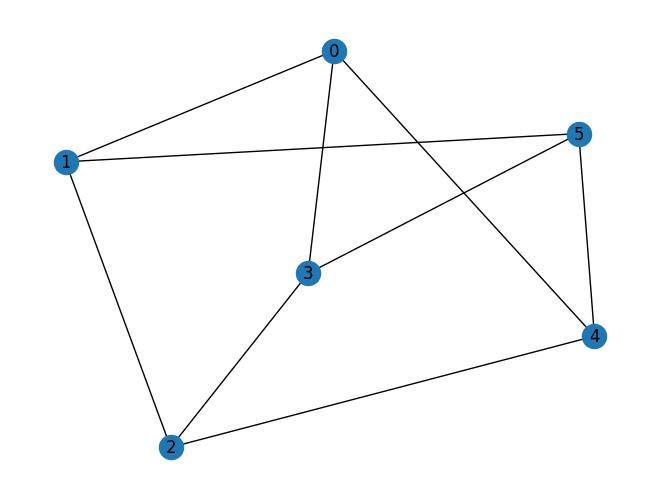

In [18]:
from qiskit_optimization.algorithms.qrao import EncodingCommutationVerifier

seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

As before, we `encode()` the problem using the QuantumRandomAccessEncoding class:

In [19]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

print("Encoded Problem:\n=================")
print(encoding.qubit_op)  # The Hamiltonian without the offset
print("Offset = ", encoding.offset)
print("Variables encoded on each qubit: ", encoding.q2vars)

Encoded Problem:
SparsePauliOp(['XX', 'XY', 'XZ', 'YX', 'ZX', 'YY', 'YZ', 'ZY', 'ZZ'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j])
Offset =  -4.5
Variables encoded on each qubit:  [[0, 2, 5], [1, 3, 4]]


Finally, we iterate over every decision variable state using `EncodingCommutationVerifier` and verify that, in each case, the problem objective value matches the encoded objective value:

In [20]:
import numpy as np

verifier = EncodingCommutationVerifier(encoding, estimator=Estimator())
if not len(verifier) == 2**encoding.num_vars:
    print("The number results of the encoded problem is not equal to 2 ** num_vars.")

for str_dvars, obj_val, encoded_obj_val in verifier:
    if not np.isclose(obj_val, encoded_obj_val):
        print(
            f"Violation identified: {str_dvars} evaluates to {obj_val} "
            f"but the encoded problem evaluates to {encoded_obj_val}."
        )

/var/folders/f9/_1j2txjx3bn64hm6jkx7mwf80000gn/T/ipykernel_28184/768070498.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  verifier = EncodingCommutationVerifier(encoding, estimator=Estimator())


If you are able to construct a problem that causes a violation, it is quite possible that you have discovered a bug in the `QuantumRandomAccessEncoding` logic. We would greatly appreciate it if you could share the problem with us by [submitting it as an issue](https://github.com/Qiskit/qiskit-optimization/issues) on GitHub.

In [21]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright